# Visualisation of SOTA results

load and preprocess dataset

In [1]:
from fco2models.utraining import prep_df
import pandas as pd
import xarray as xr
import numpy as np

def add_xco2(df):
    selector = df[['lat_005', 'time_1d']].to_xarray()
    # rename the columns to match the xarray dataset
    selector = selector.rename({'lat_005': 'lat', 'time_1d': 'time'})
    xco2mbl = xr.open_dataarray('../data/atmco2/xco2mbl-timeP7D_1D-lat25km.nc')
    matched_xco2 = xco2mbl.sel(**selector, method='nearest').to_series()
    
    df['xco2'] = matched_xco2

    return df 

dfs = []
for year in range(1982, 2022):
    df = pd.read_parquet(f'../data/SOCATv2024-1d_005deg-colloc-r20250224/SOCATv2024_1d_005deg_collocated_{year}-r20250224.pq')
    df.reset_index(inplace=True)
    df['year'] = year
    df = add_xco2(df)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
#add day_of_year column
df['day_of_year'] = df['time_1d'].dt.dayofyear
# renane lon and lat columns
df = df.rename(columns={'lon_005':'lon', 'lat_005': 'lat'})
# df['chl_globcolour'] = np.log(df['chl_globcolour'].clip(1e-5, None))
# df['mld_dens_soda'] = np.log(df['mld_dens_soda'].clip(1e-5, None))
df = prep_df(df, bound=True)[0]

2025-05-18 10:50:21,653 - INFO - salinity stacking
2025-05-18 10:50:21,743 - INFO - adding positional and temporal encodings
2025-05-18 10:50:23,064 - INFO - add climatology data
2025-05-18 10:50:41,979 - INFO - removing xco2 levels from fco2rec_uatm
2025-05-18 10:50:42,013 - INFO - replacing outliers with Nans, fco2rec_uatm > 400


In [2]:
df.columns

Index(['index', 'expocode', 'time_1d', 'lat', 'lon', 'sst_deg_c', 'sal',
       'pppp_hpa', 'woa_sss', 'ncep_slp_hpa', 'dist_to_land_km',
       'fco2rec_uatm', 'fco2rec_flag', 'n_samples', 'temp_soda', 'salt_soda',
       'lon_soda', 'lat_soda', 'depth_soda', 'time_soda', 'sst_cci',
       'sst_cci_uncertainty', 'ice_cci', 'time_sstcci', 'lat_sstcci',
       'lon_sstcci', 'mld_dens_soda', 'time_avg', 'year', 'xco2', 'ssh_adt',
       'ssh_sla', 'lat_sshcm', 'lon_sshcm', 'time_sshcm', 'chl_globcolour',
       'chl_globcolour_uncert', 'chl_globcolour_flags', 'time_chlgc',
       'lat_chlgc', 'lon_chlgc', 'sss_cci', 'sss_cci_random_error',
       'lat_ssscci', 'lon_ssscci', 'time_ssscci', 'day_of_year',
       'sin_day_of_year', 'cos_day_of_year', 'sin_lat', 'sin_lon_cos_lat',
       'cos_lon_cos_lat', 'sin_lon', 'cos_lon', 'is_north', 'co2_clim8d'],
      dtype='object')

In [3]:
# remove entries with high ice concentration
#df = df[df.ice_cci < 0.8]

load the model

In [4]:
import json
from fco2models.ueval import load_models, print_loss_info
from fco2models.umeanest import MLPModel

save_dir = '../models/sota/'
model_path = 'e_30.pt'
model_name = 'sota_mlp'
model_info = {
    model_name: [save_dir, model_path, MLPModel]
    }

models = load_models(model_info)
train_loss = models['sota_mlp']['losses']['train_losses']
val_loss = models['sota_mlp']['losses']['val_losses']
model_info = models['sota_mlp']


In [5]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from fco2models.umeanest import predict_mean_eval, get_loader_point_ds
from fco2models.utraining import normalize_dss

params = model_info['params']
predictors = params['predictors']

train_stats = dict([
    ('means', params['train_means']),
    ('stds', params['train_stds']),
    ('mins', params['train_mins']),
    ('maxs', params['train_maxs'])
              ])

mode = params['mode']
model = model_info['model']
target = 'fco2rec_uatm'

cols = [target] + predictors
df_clean = df[cols].dropna()
dataloader = get_loader_point_ds(df_clean, train_stats, mode)
losses, preds = predict_mean_eval(model, dataloader, is_sequence=False)

2025-05-18 10:50:44,741 - INFO - Using given stats for normalization
2025-05-18 10:50:44,741 - INFO - Normalizing data using mean_std normalization
2025-05-18 10:50:44,741 - INFO - Not normalizing features: []


Predicting on cuda


Predicting: 100%|██████████| 2771/2771 [00:43<00:00, 63.83it/s, Loss=0.022]  


In [6]:
test_months = pd.date_range('1982-01', '2022-01', freq='7MS').values.astype('datetime64[M]')
months = df.time_1d.values.astype('datetime64[M]')
mask_test = np.isin(months, test_months)

add predictions to original dataframe

In [7]:
df_clean['predictions'] = preds.squeeze(-1)
df.loc[df_clean.index, 'predictions'] = df_clean['predictions'] * train_stats['stds'][0] + train_stats['means'][0]
df['residuals'] = df['fco2rec_uatm'] - df['predictions']
group_cols = ['lat', 'lon']
plotting_data = (
    df.loc[:, group_cols + ['predictions', 'fco2rec_uatm', 'residuals']]
    .groupby(group_cols)
    .mean()
    .to_xarray()
    .coarsen(lat=20, lon=20, boundary='pad')
    .mean())

(np.float64(-179.99999999999997),
 np.float64(180.00000000000003),
 np.float64(-78.7),
 np.float64(90.15000000000002))

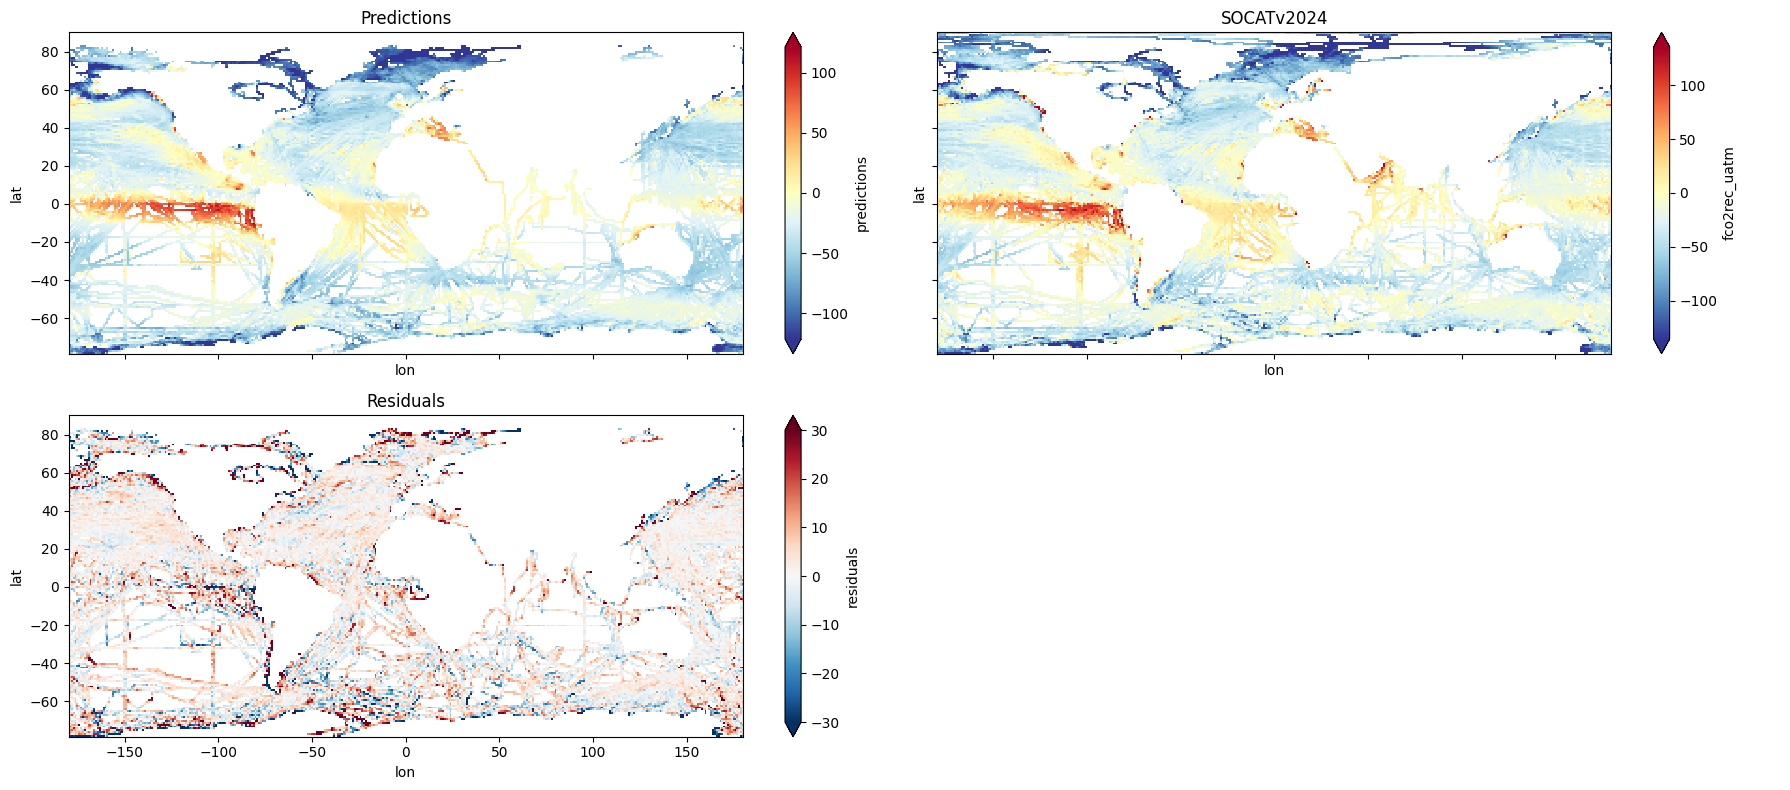

In [8]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(18, 8), sharex=True, sharey=True)
plotting_data.predictions.plot.imshow(robust=True, ax=axs[0, 0], cmap='RdYlBu_r',)
axs[0, 0].set_title('Predictions')
plotting_data.fco2rec_uatm.plot.imshow(robust=True, ax=axs[0, 1], cmap='RdYlBu_r')
axs[0, 1].set_title('SOCATv2024')
plotting_data.residuals.plot.imshow(robust=True, ax=axs[1, 0], cmap='RdBu_r', vmin=-30, vmax=30)
axs[1, 0].set_title('Residuals')

plt.tight_layout()
axs[1, 1].axis('off')

In [9]:
mask_test.shape

(6651249,)

In [16]:
# import rmse 
from sklearn.metrics import root_mean_squared_error
# import r2_score
from sklearn.metrics import r2_score
def get_error_stats(df):
    nan_mask = df['predictions'].isna()
    rmse = root_mean_squared_error(df.loc[~nan_mask, 'fco2rec_uatm'], df.loc[~nan_mask, 'predictions'])
    print(f'RMSE: {rmse:.2f}')
    r2 = r2_score(df.loc[~nan_mask, 'fco2rec_uatm'], df.loc[~nan_mask, 'predictions'])
    print(f'R2: {r2:.2f}')
    # bias
    bias = np.nanmean(df.loc[~nan_mask, 'residuals'])
    print(f'Bias: {bias:.2f}')

In [17]:
print("train errors:")
get_error_stats(df.loc[~mask_test])
print("test errors:")
get_error_stats(df.loc[mask_test])

train errors:
RMSE: 21.09
R2: 0.88
Bias: 1.44
test errors:
RMSE: 25.33
R2: 0.79
Bias: 2.36


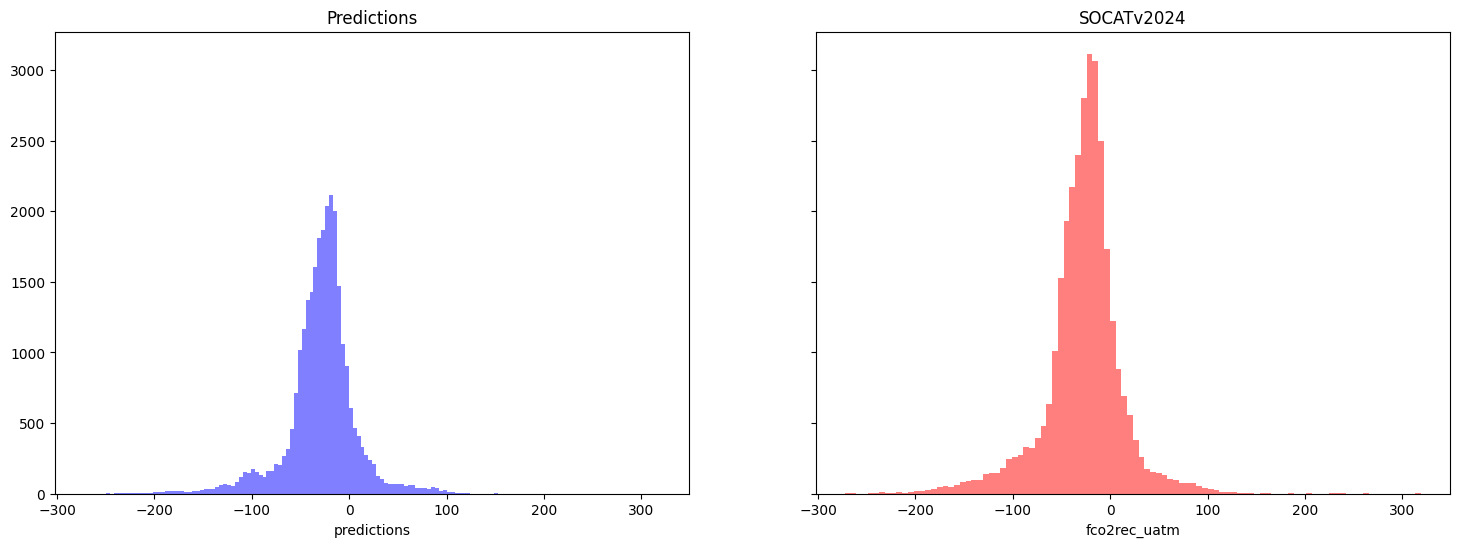

In [18]:
# plot histogramns of predictions and fco2rec_uatm
fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharex=True, sharey=True)
plotting_data.predictions.plot.hist(ax=axs[0], bins=100, color='blue', alpha=0.5, label='predictions')
axs[0].set_title('Predictions')
plotting_data.fco2rec_uatm.plot.hist(ax=axs[1], bins=100, color='red', alpha=0.5, label='fco2rec_uatm')
axs[1].set_title('SOCATv2024')
plt.show()

In [19]:
from sklearn import metrics
def plot_line_comparison(ax, y, yhat, **kwargs):
    from scipy.stats import pearsonr

    y.plot(ax=ax, **(kwargs | dict(label='SOCAT')))
    yhat.plot(ax=ax, **kwargs)
    
    m = y.notnull() & yhat.notnull()
    y = y[m]
    yhat = yhat[m]
    
    metric_txt = (
        f"r2 = {metrics.r2_score(y, yhat):.2f}"
        f"\nRMSE = {metrics.root_mean_squared_error(y, yhat):.1f}"
        f"\nBias = {(yhat - y).mean():.1f}"
        f"\nPearson R = {pearsonr(y, yhat)[0]:.2f}")
    
    ax.text(0.01, 0.04, metric_txt, transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom')
    
    ax.legend()

In [20]:
cruise_idx = 831

expocode = df.expocode[mask_test].value_counts().index[cruise_idx]
df_cruise = df[df.expocode == expocode].dropna(subset=['predictions', 'fco2rec_uatm'])



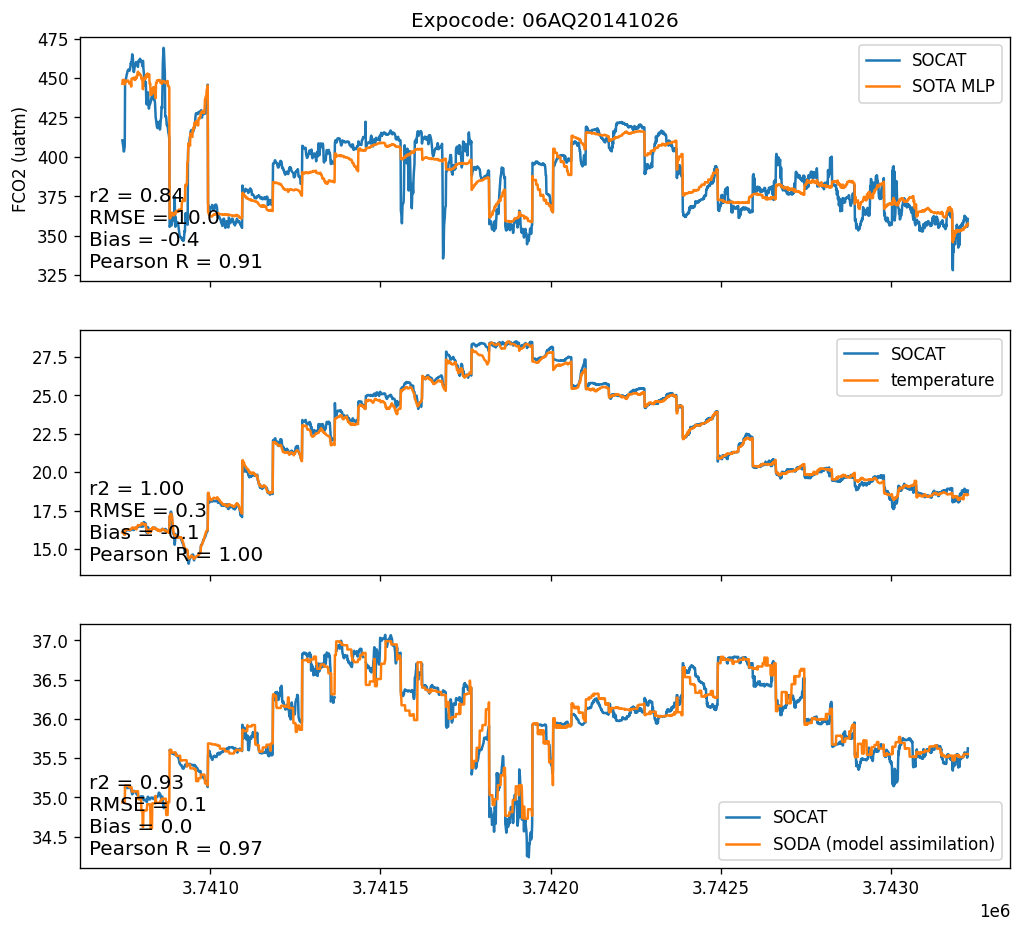

In [21]:
cruise_idx = 831

# expocode = df.expocode[mask_test].value_counts().index[cruise_idx]
expocode = '06AQ20141026'
df_cruise = df[df.expocode == expocode].dropna(subset=['predictions', 'fco2rec_uatm'])

fig, axs = plt.subplots(3, 1, figsize=(10, 9), sharex=True, sharey=False, dpi=120)

axs[0].set_title(f'Expocode: {expocode}')
axs[0].set_ylabel('FCO2 (uatm)')
plot_line_comparison(axs[0], df_cruise.fco2rec_uatm + df_cruise.xco2, df_cruise.predictions + df_cruise.xco2, label='SOTA MLP')
plot_line_comparison(axs[1], df_cruise.sst_deg_c, df_cruise.sst_cci-273.15, label='temperature')
plot_line_comparison(axs[2], df_cruise.sal, df_cruise.salt_soda, label='SODA (model assimilation)')